In [1]:
# initalization

import mne
import os
import scipy.io
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy import signal

import pandas as pd
import pickle
import warnings
warnings.filterwarnings('ignore')
from itertools import permutations,combinations
from IPython.display import clear_output
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


from mne.decoding import ReceptiveField
from sklearn.model_selection import KFold
data_path = os.path.dirname(os.path.dirname(os.getcwd()))


save_path = data_path + '/python/data/coherence'
info = mne.io.read_raw_fif((save_path+'-info'),preload=True)

subject_name = ['Alice','Andrea','Daniel','Elena','Elenora','Elisa','Federica','Francesca','Gianluca1','Giada','Giorgia',
                'Jonluca','Laura','Leonardo','Linda','Lucrezia','Manu','Marco','Martina','Pagani','Pasquale','Sara',
                'Silvia','Silvia2','Tommaso']

clear_output()

# load data

In [2]:
# read epoches
Tmin = 0
Tmax = 3.51
trial_len = 2

GA_epoches = []
for s in subject_name:
    save_path = data_path + '/python/data/coherence_epochs/'+s+'-coh-epo-'+str(Tmin)+'-' \
    +str(Tmax)+'-trialLen-'+str(trial_len)+'_normalized.fif'
    a = mne.read_epochs(save_path)
    GA_epoches.append(a)
    print('----------------------------------------------------------------------------------------------------------------'+s)
clear_output()


In [3]:
# data prepocessing and model parameters

features1 = np.array(['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD'])
features = ['envelop','lipaparature']
#extra_channels_idx = np.where(features1==features)[0][0]

#eeg_channles = []    
#for s in range(0,n_components):
    #eeg_channles.append('Component'+str(s))
    
eeg_channles = info.ch_names[0:59]
#eeg_channles = ['FC6','FC5']
    

rsfreq = 100

con = ['hyper','normal','hypo','All']
con = 'All'

delay = np.arange(-5,5.5,0.5) / 10
delay = [0]


remove_first = 0.5 #seconds
trial_len = 2


# filter data
fmin=1
fmax=4

# model parameters
tmin, tmax = -0.5, 0.5
n_splits = 3

rf = ReceptiveField(tmin, tmax, rsfreq, feature_names=eeg_channles,estimator=1e2, 
                    scoring='corrcoef', patterns=True)

# data preprocess

In [4]:
# resample
for s in range(0,len(subject_name)):
    GA_epoches[s].resample(rsfreq, npad='auto')

In [5]:
# filtering
A = []
for s in range(0,len(subject_name)):
    GA_epoches[s].filter(fmin,fmax)
    
clear_output()

In [ ]:
# eeg dimention reduction (PCA)

n_components=20

# Make an instance of the Model
pca = PCA(n_components=n_components)

eeg_data = []
speech_data = []

explained_var = []
for s in range(0,len(subject_name)):
    X = GA_epoches[s].get_data()[:,0:59,:]
    x = np.hstack(X)
    x = pca.fit_transform(x.T).T
    x = np.stack(np.split(x, X.shape[0], axis=1))
    eeg_data.append(x)
    explained_var.append(pca.explained_variance_ratio_.sum())
    
    X = GA_epoches[s].get_data()[:,59:66,:]
    speech_data.append(X)

    
explained_var = np.asarray(explained_var)  
explained_var

# decoding

In [6]:
# functions
def coherence_preprocess_delay(epochs,remove_first,d,trial_len,extra_channels,eeg_channles,condition):	

    if condition != 'All':
        E = epochs[condition].copy()
    else:
        E = epochs.copy()
        
    eeg = E.copy().pick_channels(eeg_channles)
    speech = E.copy().pick_channels(extra_channels)

    E = eeg.copy().crop(d+remove_first,d+remove_first+trial_len)
    S = speech.copy().crop(0.5+remove_first,0.5+remove_first+trial_len)
    
    #E = eeg.copy().crop(0.5+remove_first,0.5+remove_first+trial_len)
    #S = speech.copy().crop(d+remove_first,d+remove_first+trial_len)
        
    return E.get_data(),S.get_data()

def get_data(ee,ss,remove_first,d,trial_len,extra_channels_idx):	

    start_i = int((d+remove_first)*sfreq)
    end_i = int((d+remove_first+trial_len)*sfreq)
    
    E = ee[:,:,start_i:end_i]
    
    start_i = int((0.5+remove_first)*sfreq)
    end_i = int((0.5+remove_first+trial_len)*sfreq)
    
    S = ss[:,extra_channels_idx,start_i:end_i]
    S = np.expand_dims(S, axis=1)
    return E,S


def restructure_data(eeg,ema):
    Y = np.swapaxes(eeg,0,1)
    eeg = np.swapaxes(Y,0,2)
    speech = np.swapaxes(ema,0,1)
    ema = np.swapaxes(speech,0,2)
    return eeg,ema


def deoding_fromEEG(speech,eeg,tmax,tmin,n_splits,rsfreq):
    # Define the delays that we will use in the receptive field

    n_channels = eeg.shape[1]    
    # We'll have (tmax - tmin) * sfreq delays
    # and an extra 2 delays since we are inclusive on the beginning / end index
    n_delays = int((tmax - tmin) * rsfreq) + 2 -1

    cv = KFold(n_splits)

    # Iterate through splits, fit the model, and predict/test on held-out data
    coefs = np.zeros((n_splits, n_channels, n_delays))
    patterns = coefs.copy()
    scores = np.zeros((n_splits,))
    for ii, (train, test) in enumerate(cv.split(speech)):
        print('split %s / %s' % (ii + 1, n_splits))
        eeg_Y,speech_Y = restructure_data(eeg[train],speech[train])        
        rf.fit(eeg_Y, speech_Y)
        
        eeg_Y,speech_Y = restructure_data(eeg[test],speech[test])
        scores[ii] = rf.score(eeg_Y, speech_Y)[0]
        
        # coef_ is shape (n_outputs, n_features, n_delays). We have 128 features
        coefs[ii] = rf.coef_[0, :, :]
        patterns[ii] = rf.patterns_[0, :, :]
    times = rf.delays_ / float(rf.sfreq)

    # Average scores and coefficients across CV splits
    mean_coefs = coefs.mean(axis=0)
    mean_patterns = patterns.mean(axis=0)
    mean_scores = scores.mean(axis=0)
    max_coef = np.abs(mean_coefs).max()
    max_patterns = np.abs(mean_patterns).max()

    clear_output()
    return mean_scores,mean_coefs,mean_patterns

def scalling_data(data):
    scaler = MinMaxScaler()
    A = data
    for i in range(0,data.shape[1]):
        A[:,i,:] = scaler.fit_transform(data[:,i,:])
    return A

In [ ]:
# decoding form eeg
frame = []
for s in range(0,len(subject_name)):
    for d in delay:
        for f in features:
            eeg,ema = coherence_preprocess_delay(GA_epoches[s],remove_first,d+0.5,trial_len,
                                                 [f],eeg_channles,con)    

            # scale in 0,1 range
            eeg = scalling_data(eeg)
            ema = scalling_data(ema)
            # train
            mean_scores,mean_coefs,mean_patterns = deoding_fromEEG(ema,eeg,tmax,tmin,n_splits,rsfreq)

            df = pd.DataFrame({'subject':subject_name[s],'Delay':d,'Features':f,
                               'mean_scores': mean_scores,'mean_coefs': [mean_coefs],
                               'mean_patterns': [mean_patterns]})
            frame.append(df)        
            print(str(d)+'-'+subject_name[s])

data = pd.concat((frame),axis=0)
save_path = data_path + '/python/data/mvpa/decoding_0delay_Freq_'\
            +str(fmin)+'_'+str(fmax)+'_01normalized.pkl'
data.to_pickle(save_path)

clear_output()

0-Francesca
split 1 / 3
split 2 / 3
split 3 / 3


# data analysis

In [8]:
# read  data
save_path = data_path + '/python/data/mvpa/decoding_0delay_Freq_1_4.pkl'
save_path = data_path + '/python/data/mvpa/decoding_0delay_Freq_1_4_01normalized.pkl'

data_decode=pd.read_pickle(save_path)
data_decode.head()

,Delay,Features,mean_coefs,mean_patterns,mean_scores,subject
0,0,envelop,"[[-0.0045032307263755495, -0.00438200298460414...","[[-3.1794089186453636e-09, -3.060759843676292e...",0.288122,Alice
0,0,lipaparature,"[[-0.0034988549293682816, -0.00406740148212296...","[[-1.9190251179708386e-07, -2.1740481981316996...",0.174338,Alice
0,0,envelop,"[[-5.735674529560932e-05, -0.00042848161810950...","[[-2.336893816670797e-08, -2.6339700734480715e...",0.351105,Andrea
0,0,lipaparature,"[[-0.0002886008051284137, 0.000278518382364027...","[[4.229472569070252e-08, 2.295549082735899e-08...",0.264531,Andrea
0,0,envelop,"[[-0.014700135942850473, -0.014742288895129787...","[[4.035040522934592e-08, 2.3342213492783986e-0...",0.278702,Daniel


In [9]:
# data investigate functions

def restructure_data(data_decode,D,feature,coeff):   
    d = np.round(np.arange(-0.5,0.51,0.01),2)

    A = data_decode[data_decode['Features']==feature]
    A = np.stack(A[coeff].get_values())
    A = np.mean(A,axis=0)
    frame=[]
    for i in range(0,len(d)):
        df = pd.DataFrame({'lag':-d[i],'Data':[A[:,i]]})
        frame.append(df)        

    data = pd.concat((frame),axis=0)
    A = data[data['lag'].isin(D)]
    Vmin = np.stack(A['Data'].get_values()).min()
    Vmax = np.stack(A['Data'].get_values()).max()
    return A,Vmin,Vmax

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].any() 
    mne.viz.plot_topomap(x, info.info, show=False,vmin=Vmin,vmax=Vmax,cmap='RdBu_r')
    #mne.viz.plot_topomap(x, info.info, show=False,cmap='RdBu_r')

def plot_topo_image(df,vmin,vmax,typeF):
    fg = sns.FacetGrid(df,col=typeF,margin_titles=True)
    b = fg.map_dataframe(draw_heatmap, 'Data')
    b = b.set_xlabels('')
    b.fig.subplots_adjust(top=0.7)
    b.fig.subplots_adjust(right=0.8)
    cbar_ax = b.fig.add_axes([0.82,0.25,0.01,0.45]) # [left, bottom, width, height] 
    norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax,label='weight amplitude')



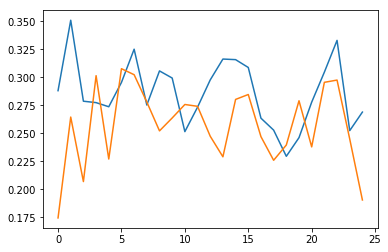

In [10]:
# subject model performance scores
d = np.round(np.arange(-0.5,0.51,0.01),2)

A = data_decode[data_decode['Features']=='envelop']
A = np.stack(A['mean_scores'].get_values())
plt.plot(A)

A = data_decode[data_decode['Features']=='lipaparature']
A = np.stack(A['mean_scores'].get_values())
plt.plot(A)

In [15]:
features = ['envelop','lipaparature']
D = np.arange(-5,5.5,0.5) / 10
#D = np.arange(-5,6) / 10

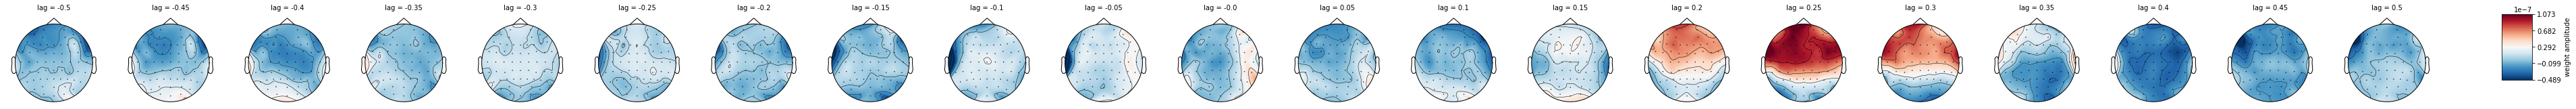

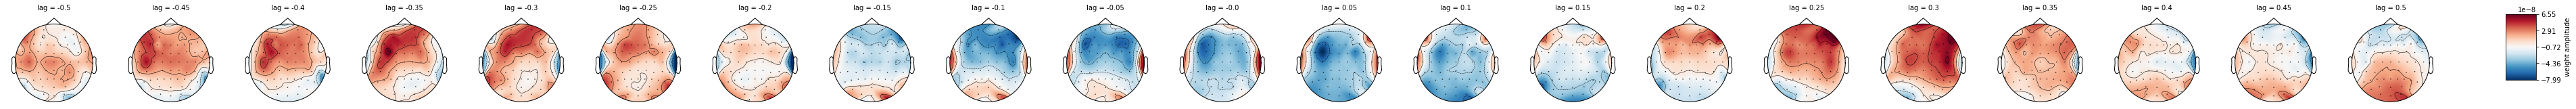

In [21]:
# Inverse-transformed coefficients (Haufe et. al. 2014)
A,Vmin,Vmax = restructure_data(data_decode,D,'envelop','mean_patterns')
plot_topo_image(A,Vmin,Vmax,'lag')

B,Vmin,Vmax = restructure_data(data_decode,D,'lipaparature','mean_patterns')
plot_topo_image(B,Vmin,Vmax,'lag')



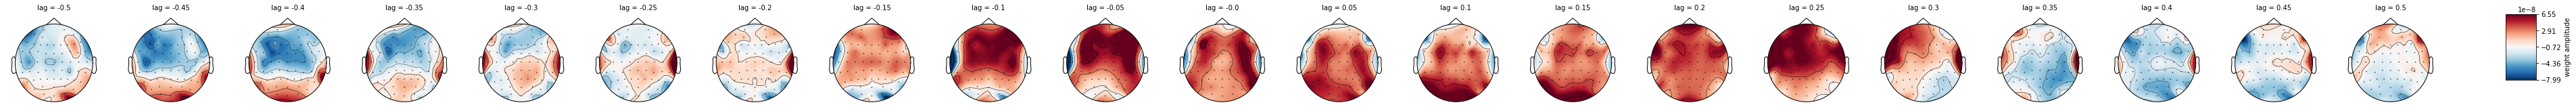

In [28]:
C = pd.concat(((A['Data']-B['Data']),A['lag']),axis=1)
plot_topo_image(C,Vmin,Vmax,'lag')


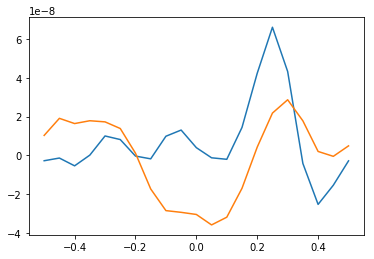

In [17]:
# channel avg in lags
a = np.stack(A['Data'].get_values()).mean(axis=1)
plt.plot(-D,a)

a = np.stack(B['Data'].get_values()).mean(axis=1)
plt.plot(-D,a)

In [ ]:
from sklearn.preprocessing import scale

i=2
y_pred = rf.predict(scaler.fit_transform(eeg[test[i]].T))

original = scale(speech[test[i]].T)
y_pred = scale(y_pred)

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(original,color='grey', lw=2, ls='--')
ax.plot(y_pred, color='r', lw=2)

ax.legend([lns[0], ln1[0]], ['Envelope', 'Reconstruction'], frameon=False)
ax.set(title="Stimulus reconstruction")
ax.set_xlabel('Time (s)')
mne.viz.tight_layout()

In [ ]:
# plot delay coorection scores for speech to eeg
CMAP = 'RdBu_r'
delay = np.arange(-5,5.5,0.5) / 10
delay = np.arange(-5,6) / 10


frame=[]
for d in delay:
    a = pd.DataFrame({'Delay':d,'Data':[data[(data['Delay']==d)]['scores'].get_values().mean(axis=0)]})
    frame.append(a)
                 
df = pd.concat((frame),axis=0)


a=[]
for d in range(0,len(delay)):
    a.append([df['Data'].get_values()[d].max(),df['Data'].get_values()[d].min()])

a=np.asarray(a)
vmax = np.max(a[:,0])
vmin = np.min(a[:,1])

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].any() 
    mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax,cmap=CMAP)

def plot_topo_image(df,vmin,vmax,typeF,cmap):
    fg = sns.FacetGrid(df,col=typeF,margin_titles=True)
    b = fg.map_dataframe(draw_heatmap, 'Data')
    b = b.set_xlabels('')
    b.fig.subplots_adjust(top=0.7)
    b.fig.subplots_adjust(right=0.8)
    cbar_ax = b.fig.add_axes([0.82,0.25,0.01,0.45]) # [left, bottom, width, height] 
    norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax,label='Score (r)')
    
plot_topo_image(df,vmin,vmax,'Delay',CMAP) 